___
## Attempt to convert osm to geojson failed - how to download maps dynamically?

In [1]:
# min_long = 37.52408
# min_lat = 55.70015
# max_long = 37.54093
# max_lat = 55.70514
# addr = "\"https://api.openstreetmap.org/api/0.6/map?bbox=" \
#     + str(min_long)  + ',' + str(min_lat) + ',' + str(max_long) + ',' + str(max_lat) + '"'

# !curl -o test_map.osm $addr

# import shutil
# import sys
# !mv test_map.osm data
# # with open('data/test_map.osm', encoding='utf-8') as file:
# #     shutil.copyfileobj(file, sys.stdout)

In [2]:
# import codecs
# import osm2geojson
# import geopandas

# with codecs.open('data/test_map.osm', 'r', encoding='utf-8') as data:
#     xml = data.read()

# geojson = osm2geojson.xml2geojson(xml, filter_used_refs=False, log_level='INFO')

# gp.read_file(geojson)

___
## Parsing predownloaded pbf maps

In [2]:
import geopandas
from pyrosm import OSM

[Parts of the world](http://download.geofabrik.de/)  
[Cities](https://download.bbbike.org/osm/bbbike/)  
[Choose borders](https://extract.bbbike.org/)  
[OSM API](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL) - possible solution

In [104]:
minx = 35.9
miny = 56.575 # 56.5825 # 56.575
maxx = 36.12 # 35.98 # 36.12
maxy = 56.6
bbox_width = maxx - minx
bbox_length = maxy - miny

<AxesSubplot:>

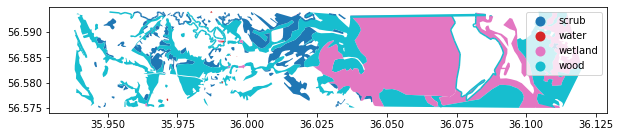

In [105]:
osm = OSM("maps/kozlovo.osm.pbf", bounding_box=[minx, miny, maxx, maxy])
# custom_filter = {"natural" : True}
# natural = osm.get_data_by_custom_criteria(custom_filter = custom_filter, keep_nodes = True)
natural = osm.get_natural(extra_attributes=['nodes'])
natural.plot(column='natural', legend=True, figsize=(10,6))
# print("\nAdditional attributes in the 'tags': \n", natural.tags.unique())

In [106]:
natural.tail(2)

,natural,water,wetland,id,timestamp,version,geometry,osm_type,changeset,tags
128,wood,NaN,None,389889442,0,-1,"POLYGON ((35.97847 56.57711, 35.97948 56.57746...",relation,0.0,"{""type"":""multipolygon""}"
129,wood,NaN,None,422265022,0,-1,"POLYGON ((36.04903 56.57530, 36.04857 56.57586...",relation,0.0,"{""type"":""multipolygon""}"


In [107]:
natural.geometry.type.unique()

array(['Polygon', 'MultiLineString', 'MultiPolygon'], dtype=object)

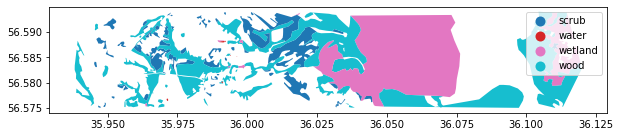

In [108]:
polygons = natural.loc[:, ['natural', 'geometry']].loc[natural.geometry.type == 'Polygon']
if not polygons.empty:
    polygons.plot(column='natural', legend=True, figsize=(10,6));

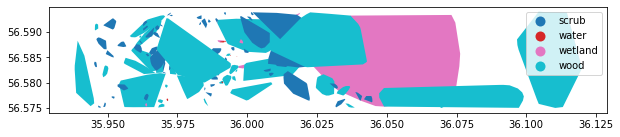

In [109]:
polygons.geometry = polygons.geometry.convex_hull # check for efficiency and rewrite if needed
polygons.plot(column='natural', legend=True, figsize=(10,6));

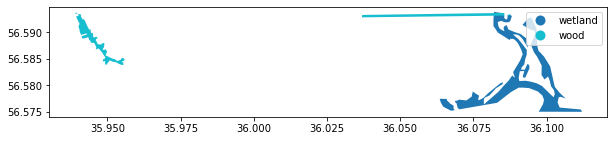

In [110]:
multipolygons = natural.loc[:, ['natural', 'geometry']].loc[natural.geometry.type == 'MultiPolygon']
if not multipolygons.empty:
    multipolygons.plot(column='natural', legend=True, figsize=(10,6));

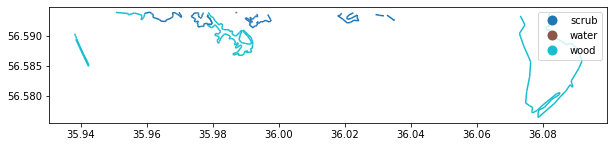

In [111]:
multilinestrings = natural.loc[:, ['natural', 'geometry']].loc[natural.geometry.type == 'MultiLineString']
if not multilinestrings.empty:
    multilinestrings.plot(column='natural', legend=True, figsize=(10,6));

___
## Find optimal pair

In [11]:
import numpy as np
import math

def vec(a, b):
    return np.array(b) - np.array(a)

def mod(v):
    return (v[0]**2 + v[1]**2)**0.5

def angle(a, b, c):
    mods = mod(vec(b, a)) * mod(vec(b, c))
    if mods == 0:
        return 1
    cos = np.dot(vec(b,a), vec(b,c)) / mods
    if math.fabs(cos) > 1:
        return 1
    return math.acos(cos)

def point_in_angle(p, a, b, c):
    delta = 0.00000001
    return math.fabs(angle(a, b, c) - angle (a, b, p) - angle(p, b, c)) < delta

In [12]:
def find_pair(point, left_border, right_border, coord):
    n = len(coord) - 1
    # optimize list work
    b = [1 for i in range(n)]
    count = 0
    for i in range(n):
        if not point_in_angle(point, coord[(i-1)%n], coord[i%n], coord[(i+1)%n]) and \
                not point_in_angle(coord[i%n], left_border, point, right_border):
            b[i] = 0
            count += 1
    if count == 0:
        return 1, 1
    if count == n:
        # print("Point inside a polygon")
        return 1, 1
    if b[0] == 1:
        start = b.index(0, 1)
        if b[n-1] == 0:
            end = n-1
        else:
            end = b.index(1, start + 1)
            end -= 1
    if b[0] == 0:
        start = b.index(1, 1)
        start -= 1
        if b[n-1] == 1:
            end = n
        else:
            end = b.index(0, start + 1)
    return start, end

In [13]:
def find_pair2(point, left_border, right_border, coord):
    n = len(coord) - 1
    begin = end = -1
    for i in range(n):
        if not point_in_angle(point, coord[(i-1)%n], coord[i%n], coord[(i+1)%n]) and \
                not point_in_angle(coord[i%n], left_border, point, right_border):
            if i == 0:
                start_zero = True
            if begin == -1 and not start_zero:
                begin = i
            if start_zero and end != -1:
                begin = i
                return min(begin, end), max(begin, end)
            if not start_zero and i == n - 1:
                end = n - 1
                return min(begin, end), max(begin, end)
        else:
            if i == 0:
                start_zero = False
            if begin != -1 and not start_zero:
                end = (i-1)%n
                return min(begin, end), max(begin, end)
            if start_zero and end == -1:
                end = (i-1)%n
            if start_zero and i == n - 1:
                begin = n
                return min(begin, end), max(begin, end)
    return 1, 1

___
## Build dataframes

In [14]:
from shapely.geometry import Polygon, mapping, MultiPolygon, MultiLineString
import matplotlib.pyplot as plt
import mplleaflet
import networkx as nx
import pandas as pd
import rdp

In [15]:
epsilon = 0.001
bbox_comp = 25

def check_bounds(obj):
    bounds = obj.bounds
    return bbox_width / (bounds[2] - bounds[0]) <= bbox_comp and bbox_length / (bounds[3] - bounds[1]) <= bbox_comp

def get_coord(obj, bbox_comp):
    if bbox_comp is not None and not check_bounds(obj):
        return 0
    return rdp.rdp(np.array(mapping(obj)['coordinates'][0]), epsilon=epsilon)

def get_centroid(polygon):
    return Polygon(polygon).centroid

In [112]:
polygons = pd.DataFrame(polygons)
polygons['centroid'] = polygons.geometry.apply(get_centroid)
polygons.geometry = polygons.geometry.apply(get_coord, args=[bbox_comp])
polygons = polygons.reset_index().rename(columns={'geometry' : 'coords'}).drop(columns='index')

multipolygons = pd.DataFrame(multipolygons)
for i in range(multipolygons.shape[0]):
    multi_natural = multipolygons.natural.iloc[i]
    for polygon in MultiPolygon(multipolygons.geometry.iloc[i]).geoms:
        convex_polygon = polygon.convex_hull
        if bbox_comp is not None and not check_bounds(convex_polygon):
            coords = 0
        else: 
            coords = rdp.rdp(np.array(mapping(convex_polygon)['coordinates'][0]), epsilon = epsilon)
        polygons = polygons.append({'coords': coords,
                                    'natural': multi_natural,
                                    'centroid': convex_polygon.centroid}, ignore_index=True)

multilinestrings = pd.DataFrame(multilinestrings)
multilinestrings.geometry = multilinestrings.geometry.apply(get_coord, args=[bbox_comp])
multilinestrings = multilinestrings.reset_index().rename(columns={'geometry' : 'coords'}).drop(columns='index')

___
## Build a graph

In [76]:
def add_point(new_point, point, view_angle_std, crosses, node):
    x = new_point[0]
    y = new_point[1]
    x_rel = x - point[0]
    y_rel = y - point[1]
    dist = mod((x_rel, y_rel))
    k1 = math.ceil(math.atan2(y_rel, x_rel) * 180 / math.pi / view_angle_std)
    if crosses[k1] is None or crosses[k1][0] > dist:
        crosses[k1] = [dist, [x, y, node]]
    return x, y, x_rel, y_rel, k1

In [80]:
def add_points(point1, point2, point, view_angle_std, crosses, node1, node2):
    x1, y1, x1_rel, y1_rel, k1 = add_point(point1, point, view_angle_std, crosses, node1)
    x2, y2, x2_rel, y2_rel, k2 = add_point(point2, point, view_angle_std, crosses, node2)
    for p in range(min(k1, k2) + 1, max(k1, k2)):
        k_curr = math.tan((p * view_angle_std + 0.00001)*math.pi/180)
        if x1_rel == x2_rel:
            k_segment = 100000
        else:
            k_segment = (y1_rel - y2_rel) / (x1_rel - x2_rel)
        b_segment = y1_rel - k_segment * x1_rel
        x = b_segment / (k_curr - k_segment)
        y = k_curr * x
        if not point_in_angle((x, y), (x1_rel, y1_rel), (0, 0), (x2_rel, y2_rel)):
            continue
        dist = mod((x, y))
        if crosses[p] is None or crosses[p][0] > dist:
            crosses[p] = [dist, None]

In [100]:
def build_graph(polygons, plot=False, view_angle=None, use_centroid=False):
    fig = plt.figure()
    G = nx.MultiGraph(crs='EPSG:4326')
    max_poly_len = 10000 # for graph indexing
    polygon_number = polygons.shape[0]
    multilinestring_number = multilinestrings.shape[0]
    for i in range(polygon_number):
        coords_1 = polygons.coords[i]
        if type(coords_1) == int:
            continue
        n = len(coords_1) - 1
        for k in range(n):
            point = coords_1[k]
            left_border = coords_1[(k-1)%n]
            right_border = coords_1[(k+1)%n]
            G.add_node(i * max_poly_len + k, x=point[0], y=point[1])     
            view_angle_std = 1 if view_angle is None or view_angle == 0 else view_angle
            angle_count = math.floor(360 / view_angle_std)
            crosses = [None for p in range(angle_count)]
            for j in range(multilinestring_number):
                line_coords = multilinestrings.coords[j]
                if type(line_coords) == int:
                    continue
                m = len(line_coords) - 1
                stay = False
                for k in range(m):
                    if not stay:
                        point1 = line_coords[k]
                        point1_index = k
                    point2 = line_coords[k + 1]
                    if (min(bbox_width, bbox_length) / mod(vec(point1, point2)) > bbox_comp):
                        stay = True
                        continue
                    if view_angle is not None:
                        delta_angle = view_angle * math.pi / 180
                        if angle(point1, point, point2) < delta_angle:
                            stay = True
                            continue
                    node1 = (j + 0.33) * max_poly_len + point1_index
                    node2 = (j + 0.33) * max_poly_len + k + 1
                    G.add_node(node1, x=point1[0], y=point1[1])
                    G.add_node(node2, x=point2[0], y=point2[1])
                    G.add_edge(node1, node2)
                    add_points(point1, point2, point, view_angle_std, crosses, node1, node2)
            for j in range(polygon_number):
                if j == i: # adding nodes inside a polygon
                    for t in range (n):
                        if t == k:
                            continue
                        other_point = coords_1[t]
                        G.add_node(i * max_poly_len + t, x=other_point[0], y=other_point[1])
                        G.add_edge(i * max_poly_len + t, i * max_poly_len + k)
                        if plot:
                            plt.plot([point[0], other_point[0]], [point[1], other_point[1]])
                    continue 
                coords_2 = polygons.coords[j]
                if type(coords_2) == int:
                    continue
                left, right = find_pair(point, left_border, right_border, coords_2)
                if left == 1:
                    continue
                left_coords = coords_2[left]
                right_coords = coords_2[right]
                if view_angle is not None:
                    delta_angle = view_angle * math.pi / 180
                    if angle(left_coords, point, right_coords) < delta_angle:
                        if use_centroid:
                            node = (j + 0.66) * max_poly_len
                            G.add_node(node, x=point2[0], y=point2[1])
                            G.add_edge(node, i * max_poly_len + k)
                            add_point(polygons.centroid[j], point, view_angle_std, crosses, node)
                        continue
                add_points(left_coords, right_coords, point, view_angle_std, crosses,
                           j * max_poly_len + left, j * max_poly_len + right)
            for p in range(angle_count):
                if crosses[p] is not None and crosses[p][1] is not None:
                    G.add_node(crosses[p][1][2], x = crosses[p][1][0], y = crosses[p][1][1])
                    G.add_edge(crosses[p][1][2], i * max_poly_len + k)
                    if plot:
                        plt.plot([point[0], crosses[p][1][0]], [point[1], crosses[p][1][1]]);
    return G, fig

In [113]:
%%time
view_angle = 5
G, fig = build_graph(polygons, plot=False, view_angle=view_angle, use_centroid=False)
# mplleaflet.display(fig=fig)

CPU times: user 2.66 s, sys: 438 µs, total: 2.66 s
Wall time: 2.77 s


<Figure size 432x288 with 0 Axes>

In [114]:
print(G.number_of_edges())
print(G.number_of_nodes())

1010
124


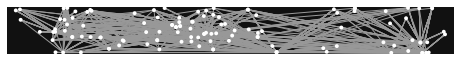

In [115]:
import osmnx as ox
ox.plot_graph(G);

___
Problems:
- Unoptimized linestring to bbox compare (should be while building dataframe)
- Possibly slow convex hull
- Additional natural attributes not in dataframe
- How to store graph?